In [1]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")

In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_openai import ChatOpenAI
from typing import Annotated

In [3]:
from templates import *
from langchain_experimental.tools import PythonREPLTool

In [4]:
python_repl_tool = PythonREPLTool()

In [14]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    """Creating an Agent"""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name='messages'),
            MessagesPlaceholder(variable_name='agent_scratchpad')
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [6]:
def agent_node(state, agent, name, log):
    result = agent.invoke(state)
    log[name] = result['output']
    return {"messages": [HumanMessage(content=result['output'], name=name)]}

In [7]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Extractor", "Validator", "Generator"]
system_prompt = (
    "你是一名监督员，负责管理以下成员之间的对话：{members}。"
    "根据以下用户请求，指定下一个需要行动的成员。每个成员将执行一个任务,"
    "你的任务是安排Extractor, Validator, 和Generator之间的工作，让他们合作教学视频中提取出完整题目及老师解析"
    "按照Extractor-Validator-Generator的顺序工作，Extractor进行初筛，Validator对于Extractor提取的每一道题进行评价，Generator根据Validator对于题目的评价决定是否保留当前题目，并输出最终满足要求的题目"
    "每一步反馈他们的结果和状态。任务完成后，请回复“FINISH”。"
)

options = ["FINISH"] + members

function_def = {
    "name": "route",
    "description": "选择下一步该由谁来执行",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ['next']
    }
}

In [12]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name='messages'),
        (
            "system",
            "请根据Extractor-Validator-Generator，的顺序选择下一个执行的人"
            "当Generator执行完，输出“FINISH” "
            "请从以下选项中选一个：{options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o", max_tokens=1000)

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [20]:
import functools
import operator
from typing import Sequence, TypedDict, Annotated

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
log = {}

extractor_agent = create_agent(llm, [python_repl_tool], extract_template)
extractor_node = functools.partial(agent_node, agent=extractor_agent, name='Extractor', log=log)

validator_agent = create_agent(llm, [python_repl_tool], validator_template)
validator_node = functools.partial(agent_node, agent=validator_agent, name="Validator", log=log)

generator_agent = create_agent(llm, [python_repl_tool], generator_template)
generator_node = functools.partial(agent_node, agent=generator_agent, name="Generator", log=log)


def supervisor_node(state, log):
    result = supervisor_chain.invoke(state)
    log["Supervisor"] = result
    return result

workflow = StateGraph(AgentState)
workflow.add_node("Extractor", extractor_node)
workflow.add_node("Validator", validator_node)
workflow.add_node("Generator", generator_node)
workflow.add_node("Supervisor", functools.partial(supervisor_node, log=log))

In [21]:
for member in members:
    workflow.add_edge(member, "Supervisor")

conditional_map = {k:k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("Supervisor", lambda x : x['next'], conditional_map)
workflow.add_edge(START, "Supervisor")

graph = workflow.compile()

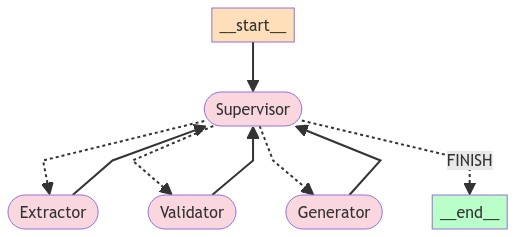

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [23]:
import json
with open("grade_7x_subtitle.json", 'r') as f:
    data = json.load(f)
data[5]

'同学们大家好首先让我们先来了解本节课的学习目标主要包括一巩固平行线的判定方法二会用判定方法判断两条直线是否平行并解决较复杂的问题三学会写几何推理过程让我们先来回顾一下学过的知识大家想一想判定两条直线平行的方法有哪些我们在平行线这一节学习过可以用平行线的定义或平行公理的推论来判断两条直线是否平行但是这两种方法有一定的局限性上节课我们又重点研究了平行线的这三种判定方法可以通过同位角相等或者内错角相等或者同旁内角互补来判断两条直线是否平行这三种判定方法也是本章的重点之一今天我们将通过几道例题继续研究这三种判定方法让我们先来看看第一道例题如图当角一等于角二时求证ab平行于CD如何证明呢请大家按下暂停键先认真思考一下相信很多同学都已经想到了证明方法要判断ab与CD是否平行只需要看角一和角三这对同位角是否相等已知条件告诉我们角一等于角二而角二和角三又是一对对顶角这样我们可以很容易地得出角一和角三相等从而证明出ab平行于CD证明过程可以这样书写因为角一等于角二已知又因为角二等于角三对顶角相等所以角一等于角三所以ab平行于CD同位角相等两直线平行当然这道题的方法并不唯一我们也可以证明角二和角四这对同位角相等或者角三和角四这对内错角相等或者角三和角五相加等于180度由同旁内角互补证明出ab平行于CD希望同学们可以熟练掌握这三种判定方法让我们来继续看例二在同一平面内如果两条直线都垂直于同一条直线那么这两条直线平行吗这道题和例一有一个明显的区别这是一道文字证明题所以我们先把这些文字转化成我们熟悉的几何语言包括符号语言和图形语言我们想证明如果B垂直于AC垂直于A那么B平行于C吗请同学们按下暂停键先认真思考一下我们先标出这道题可能会用到的角要证明B是否平行于C我们只需要证明角一和角二这对同位角是否相等或者角一和角三这对内错角是否相等或者角一和角四这对同旁内角是否互补我们知道垂直总是能和直角联系在一起所以有已知的B垂直于AC垂直于A可以得到角一角二角三角四都是90度从而这三种思路都是可行的我们选取第一种思路写出证明过程因为B垂直于AC垂直于A已知所以角一等于角二等于90度垂直的定义所以B平行于C同位角相等两直线平行这道题可以得到我们初中阶段一个重要的结论垂直于同一条直线的两条直线平行这个结论我们以后也会常常用到希望同学们能牢牢记住同学们的前两道例题掌握的怎么样让我们继续看例三如图已知角一和角

In [25]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content=data[25])
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'Supervisor': {'next': 'Extractor'}}
----
{'Extractor': {'messages': [HumanMessage(content='### 原题一：\n求解这个二元一次方程组。观察这个方程组，它比我们之前见到的较复杂了些。\n\n### 讲解一：\n回想我们以前见到的二元一次方程组，它们都是等号左边是指含有未知数的项，等号右边是只有一个数的常数项。这种形式我们称其为二元一次方程组的标准形式。之前使用消元法求解二元一次方程组都是在标准形式下进行的。\n\n现在我们题目中等号的右侧出现了未知数N，显然它并不符合标准形式。如果想继续使用消元法求解方程组，我们可以先将方程进行变形。对于第一个等式，我们可以先将两侧的括号去掉，再通过移项合并同类项得到第一个等式的标准形式：\n\\[ 4M - N = 5 \\]\n\n对于方程组中的第二个等式，虽然它已经符合了等号左边是指含有未知数的项，等号右边是只有一个数的常数项，但是我们更倾向于使用整数系数的未知数。因此我们可以将方程的左右两侧同时乘以分母的最小公倍数六，通过变形得到：\n\\[ 3M + 2N = 12 \\]\n\n达到使未知数的系数为整数的效果。这样新得到的方程组：\n\\[ 4M - N = 5 \\]\n\\[ 3M + 2N = 12 \\]\n\n这个方程组的解就是原方程组的解。将这种较复杂的二元一次方程组通过变形得到标准形式进行求解的参考格式可以为且原方程组可化为：\n\\[ 4M - N = 5 \\]\n即为一式，\n\\[ 3M + 2N = 12 \\]\n即为二式。\n\n再将2×1式再加上二式得到：\n\\[ M = 2 \\]\n\n代入一式得：\n\\[ N = 3 \\]\n\n元方程组的解是：\n\\[ M = 2, N = 3 \\]\n\n回顾这道题给我们的启发，我们可以加深记忆，解较复杂的二元一次方程组时，一般先要化简方程为标准形式且系数都化为整数，然后再进行求解。\n\n### 原题二：\n求解这个二元一次方程组。\n\n### 讲解二：\n请你按下暂停键先观察方程组，尝试做一做。我们要先将方程组化简。对于第一个等式，观察分母3、4、12，考虑两侧同时乘以12进行化简。对于第二个方程，观察分母6、2、3，考虑等号两边同时乘以6